In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-weather-surface-brazil-southeast-region/sudeste.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
plt.rcParams["patch.force_edgecolor"] = True


In [44]:
from plotly.offline import iplot, init_notebook_mode
import cufflinks as cf
import plotly.graph_objs as go
# import chart_studio.plotly as py

init_notebook_mode(connected=True)
cf.go_offline(connected=True)

# Set global theme
cf.set_config_file(world_readable=True, theme='pearl')


In [3]:
df_original = pd.read_csv("/kaggle/input/hourly-weather-surface-brazil-southeast-region/sudeste.csv", )


# Sample Data
Due to large data lets work with sampel data****

In [4]:
sample_df = df_original.sample(300000,random_state=101)

Dataset is too big so lets import in a chunk and work with the smallest one at first

## Info On Some Columns


1. Instant Air Temperature (celsius degrees) = temp
2. Maximum Air Temperature (celsius degrees) = tmin
3. Minimum Air Temperature (celsius degrees) = tmax
4. Relative Humidity of Air (%) =hmdy
5. Maximum Relative Air Humidity (%) =hmax
6. Minimum Relative Air Humidity (%) = hmin
7. Instant Dew Point (celsius degrees) = dewp
8. Maximum Dew Point (celsius degrees)=dmax
9. Minimum Dew Point Temperature (celsius degrees) = dmin
10. Instant Air Atmospheric Pressure (millibars) =stp
11. Maximum Air Atmospheric Pressure (millibars) = smax
12. Minimum Air Atmospheric Pressure (millibars)= smin
13. Instant Wind Speed (metres per second) = wdsp
14. Wind Direction (radius degrees) = wdct
15. Wind Gust Intensity (metres per second) = gust
16. Solar radiation  =  gbrd
17. Precipitation (milimetres) = prcp
18. Elevation = elvt
19. Observation Datetime = mdct
20. Observation Date = date
21. Station number (INMET number) for the location = inme
22. The year (2000-2016) : yr
23. The month (0-12) : mo
24. The day (0-31): da
25. The hour : hr

*Not all the columns are mentioned in this list*

# Tidying Data

In [5]:

print(sample_df.iloc[:,:10].head(1))
print("=="*20)
print(sample_df.iloc[:,10:20].head(1))
print("=="*20)

print(sample_df.iloc[:,20:].head(1))

        wsid        wsnm  elvt        lat        lon  inme        city prov  \
444352   307  SÃO MATEUS  29.0 -18.676198 -39.864051  A616  São Mateus   ES   

                       mdct        date  
444352  2009-09-10 16:00:00  2009-09-10  
          yr  mo  da  hr  prcp     stp    smax    smin      gbrd  temp
444352  2009   9  10  16   NaN  1017.7  1018.4  1017.7  2526.037  27.5
        dewp  tmax  dmax  tmin  dmin  hmdy  hmax  hmin  wdsp  wdct  gust
444352  18.6  28.4  19.6  26.9  18.0  58.0  63.0  55.0   4.6  92.0   7.7


Since there is no null values,under the assumption that all the data from various weather stations are valid and true, lets not filter the time of operation of weather stations and drop the wsids and inme, only city adn prov are enough.

In [6]:
sample_df.drop(['wsnm','wsid','inme'],inplace=True, axis=1)

## Dealing with Time related columns

There are five columns on time of observatoin. They are mdct, date,yr, month and hour, which are same but separated into several sctions. Among them Date and Hour columns are useful and represent all in some form, so others can be dropped. The conversion of date column to datetime gave format error.So, first do padding of year and day column then, combie as data.

In [7]:
# Padding of columns
# i.e  1->01, 2-> 02, so on.
sample_df.mo = sample_df.mo.astype(str).str.zfill(2)
sample_df.da = sample_df.da.astype(str).str.zfill(2)

In [8]:
sample_df['Date'] =  sample_df[['yr','mo','da']].astype(str).agg("-".join,axis=1)

In [9]:
sample_df['Date'] = pd.to_datetime(sample_df['Date'], format='%Y-%m-%d')

In [10]:
sample_df.drop(['mdct','yr','da','hr','mo','date'], axis= 1, inplace=True)

In [11]:
sample_df.set_index("Date", inplace=True,drop=True)

Reset Index as Date column and the check for duplicates data on same date in same city and remove them

# Missing Values 

 ## Missing Data Correlation
 
 Separate null columns and non-null ones, also the dataframes.

In [12]:
null_cols = sample_df.columns[sample_df.isnull().sum()>0]
not_null_cols = sample_df.columns[sample_df.notnull().sum()==300000]
null_df= sample_df[null_cols]
not_null_df= sample_df[not_null_cols]


Creating a function that will plot the heatmap of any dataframe, plotting the correlation between the columns in the dataframes. Moreover, this customized heatmap will remove the repitition plotting only lower diagonal elements. Plot will also only dispaly  the columns correlaton that are >-0.25 and <0.25 which are generally considered high correlation.

In [216]:
def customized_heatmap(df):
    corr_df = df.corr()
#     print(corr_df)
    missing_df =corr_df.iloc[1:,:-1].copy()  
#     print(missing_df)

    
    # Get only half portion of corr_df to avoid df, so create mask    
    mask = np.triu(np.ones_like(missing_df), k=1)
    
     
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_df, vmin=-1, vmax=1, cbar=False,
                     cmap='coolwarm', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.25 < t < 0.25:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks( size='x-large')
    plt.yticks(rotation=0, size='x-large')
    plt.savefig("Heatmap Null df")
    plt.show()
    

## Correlatoin of Null Columns in Heatmap (Fig 1.1)

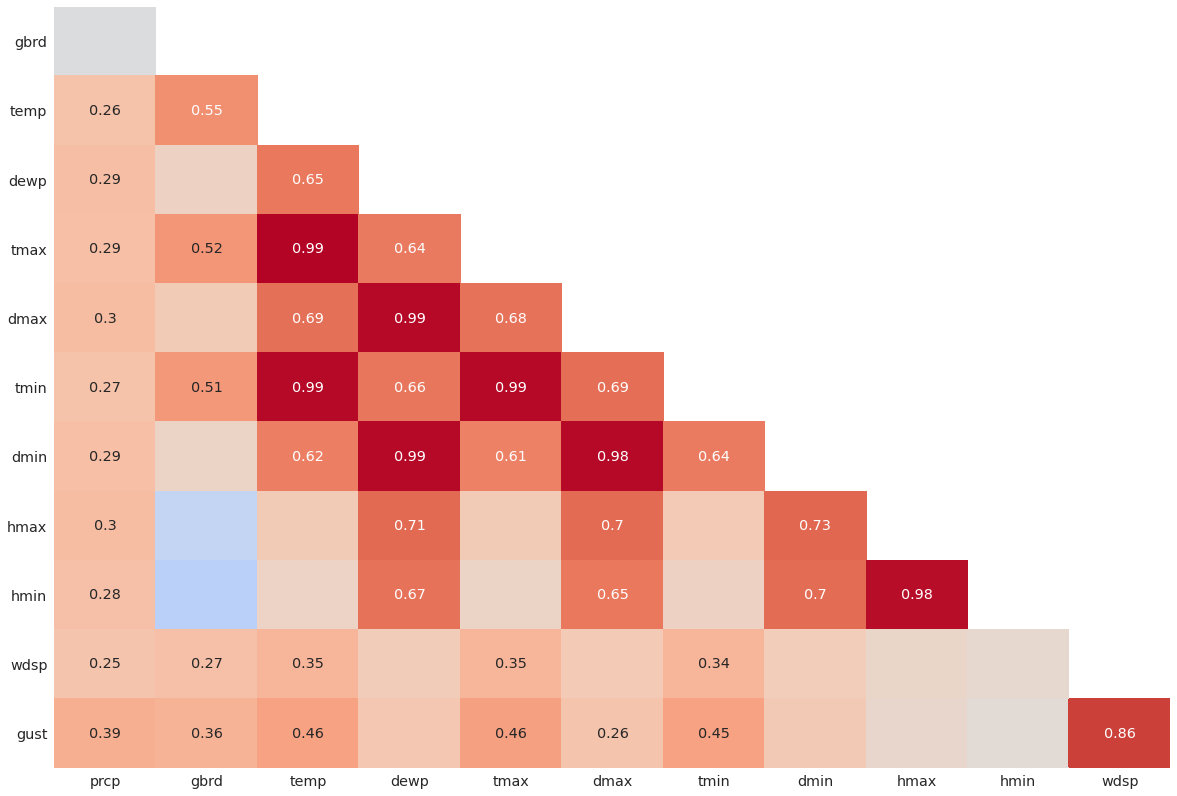

In [217]:
customized_heatmap(null_df)

The columns gust and wdsp have high correlation since they are both properties of wind. Moreover, both seem to be affected by properties of temperatures positively. 

Similary, Solar Radiation(GBRD) is also the affected by temperatures,gusts and windspeed respectively in order from higher to lower correlation. 

Dewpoint also has higher correlatin with temperature, while the highest with properties of humidity(hmin, hmax).

Lets plot the properties that have higher correlation with each other in heatmap to visualize null rows.

## Missing data percentage calculation

In [15]:
null_counts = null_df.isnull().sum()
null_counts_pct = (null_counts / sample_df.shape[0])*100

null_pct_df = pd.DataFrame({'null_counts': null_counts, 'null_pct': null_counts_pct})

print(null_pct_df.T.astype(int))

               prcp    gbrd  temp  dewp  tmax  dmax  tmin  dmin  hmax  hmin  \
null_counts  256796  126306     1    10     3    11     1    26     1     1   
null_pct         85      42     0     0     0     0     0     0     0     0   

              wdsp  gust  
null_counts  28458  9733  
null_pct         9     3  


For columns with smaller null count the percentage is very less to be shown in rounded values. 

## Missing Data Visualization Using Heatmap 

### Gust and Windspeed (fig 1.2)

In [16]:
#Plot by sorting the values by gust
sorted_df_by_temp = sample_df[['gust','wdsp',"temp"]].sort_values(['temp'] )
sorted_df_by_gust = sample_df[['gust','wdsp',"temp"]].sort_values(['gust'] )

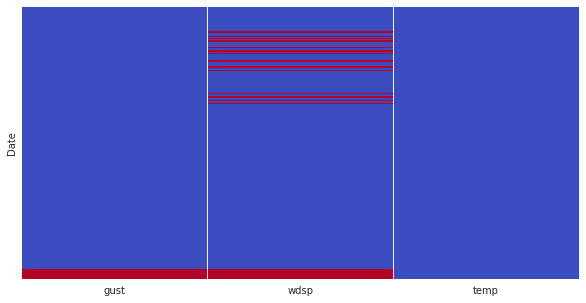

In [17]:
plt.figure(figsize=(10,5))
sns.heatmap(sorted_df_by_gust.isnull(),cmap='coolwarm', cbar=False, yticklabels=False);


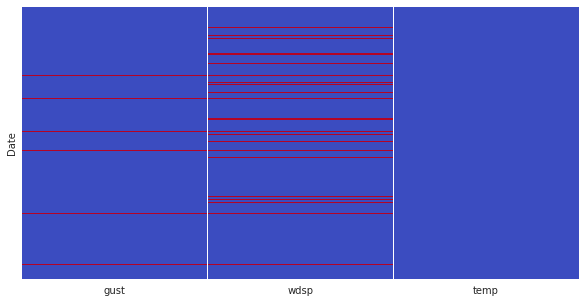

In [18]:
plt.figure(figsize=(10,5))
sns.heatmap(sorted_df_by_temp.isnull(),cmap='coolwarm', cbar=False, yticklabels=False);

After sorting the columns it seems, for all the missing values in gust there are missing values in windspeed. But according to correlation heatmap, since gust and windspeed have higher realtion than with temperature.
Lets fill the rows  where windspeed has null values but gust does not with weighted mean of windspeed by gust column. i.e create a mask where wdsp is null and gust in not null. Then divide that range again into three interval just to be more precise.

After that apply  interval technique to fill remaining rows with wighted mean of temperature columns but five intervals this time. 

In [19]:
mask_gust_wdsp = sample_df['gust'].notnull() & sample_df['wdsp'].isnull()

In [20]:
# Create interval from mask
sample_df[mask_gust_wdsp].gust.value_counts(bins=3)

(-0.0235, 7.5]    18587
(7.5, 15.0]         138
(15.0, 22.5]          5
Name: gust, dtype: int64

Create function that fills value by mask. 

In [21]:
# Create three mean 
first_range_mean_wdsp_by_gust= sample_df[sample_df['gust']<7.5]['wdsp'].mean()
second_range_mean_wdsp_by_gust=sample_df[((sample_df['gust']>=7.5) &(sample_df['gust']<15.0))]['wdsp'].mean()
third_range_mean_wdsp_by_gust=sample_df[sample_df['gust']>=15.0]['wdsp'].mean()

In [22]:
#math is imported to check nan, np.nan wont work
def fill_wdsp_by_gust(col): 
    
    
#Initialize relevant cols
    gust = col[0]
    wdsp = col[1]
    
    # If the value is nan
    #Assign by ranges declared above
    import math
    if (math.isnan(wdsp)):
        # Make sure gust in not nan
        if math.isnan(gust):
            pass
        elif (gust<7.5):
            return first_range_mean_wdsp_by_gust
        elif (gust>=7.5 ) and (gust<15.0):
            return second_range_mean_wdsp_by_gust
        elif (gust>=15.0):
            return third_range_mean_wdsp_by_gust
          #if not nan return as it is
    else:
        return wdsp
    

In [23]:
sample_df['wdsp'] = sample_df[['gust','wdsp']].apply(fill_wdsp_by_gust,axis=1)


*Temparature* column seems to have high correlation with many columns. So, lets create a function that will fill the values of columns with different interval of times and their mean with in that intervals. for this project lets try 5 intervals of temp.

Moreover, since temp is gonna determine the other columns lets drop few rows that are null in the temp column.

In [24]:
sample_df.dropna(subset=['tmax','temp','tmin'],inplace=True)

In [25]:
print(sample_df['temp'].value_counts(bins=5).sort_index())


(-3.448, 5.96]     19837
(5.96, 15.32]      27277
(15.32, 24.68]    173034
(24.68, 34.04]     77539
(34.04, 43.4]       2308
Name: temp, dtype: int64


In [26]:
# this funciton will take two cols, temp and column to fill values in this order
# the second argument is the context
# From correlation table it seems temperature has high correlation with many columns so, context will clarify which value to fill 
#by column name
#math is imported to check nan, np.nan wont work

# Create five conditions
cond_1 = sample_df[sample_df['temp']<5.96]
cond_2 = sample_df[((sample_df['temp']>=5.96) & (sample_df['temp']<15.32))]
cond_3= sample_df[((sample_df['temp']>=15.32) & (sample_df['temp']<24.68))  ]
cond_4 = sample_df[((sample_df['temp']>=24.68) & (sample_df['temp']<34.04))  ]
cond_5 = sample_df[sample_df['temp']>=34.04]


# Create five ranges of mean according to above interval for windspeed

first_range_mean_wdsp_by_temp=cond_1['wdsp'].mean()
second_range_mean_wdsp_by_temp= cond_2['wdsp'].mean()
third_range_mean_wdsp_by_temp= cond_3['wdsp'].mean()
fourth_range_mean_wdsp_by_temp= cond_4['wdsp'].mean()
fifth_range_mean_wdsp_by_temp= cond_5['wdsp'].mean()


# Create five ranges of mean according to above interval for gust

first_range_mean_gust_by_temp= cond_1['gust'].mean()
second_range_mean_gust_by_temp=  cond_2['gust'].mean()
third_range_mean_gust_by_temp= cond_3['gust'].mean()
fourth_range_mean_gust_by_temp=  cond_4['gust'].mean()
fifth_range_mean_gust_by_temp=  cond_5['gust'].mean()


# Create five ranges of mean according to above interval for solar radiation

first_range_mean_radiation_by_temp= cond_1['gbrd'].mean()
second_range_mean_radiation_by_temp=cond_2['gbrd'].mean()
third_range_mean_radiation_by_temp= cond_3['gbrd'].mean()
fourth_range_mean_radiation_by_temp=  cond_4['gbrd'].mean()
fifth_range_mean_radiation_by_temp=  cond_5['gbrd'].mean()



def fill_missing_by_temp(col, context):
    import math
    #Initialize relevant cols
    temp = col[0]
    col_1_val = col[1]
    
    # Divide the task by context
    #Either for windspeed or for gust
    
    if context == "wdsp":
      
        # If the value is nan
        #Assign by ranges declared above
        if math.isnan(col_1_val):
            if(temp<5.96):
                return first_range_mean_wdsp_by_temp
            elif(temp>=5.96) and (temp<15.32):
                return second_range_mean_wdsp_by_temp
            elif(temp>=15.32) and (temp<24.68):
                return third_range_mean_wdsp_by_temp
            elif(temp>=24.68) and (temp<34.04):
                return fourth_range_mean_wdsp_by_temp
            elif(temp>=34.04):
                return fifth_range_mean_wdsp_by_temp
            #if not nan return as it is
        else:
            return col_1_val
        
    elif context=="gbrd":
         # If the value is nan
        #Assign by ranges declared above
        if math.isnan(col_1_val):
            if(temp<5.96):
                return first_range_mean_radiation_by_temp
            elif(temp>=5.96) and (temp<15.32):
                return second_range_mean_radiation_by_temp
            elif(temp>=15.32) and (temp<24.68):
                return third_range_mean_radiation_by_temp
            elif(temp>=24.68) and (temp<34.04):
                return fourth_range_mean_radiation_by_temp
            elif(temp>=34.04):
                return fifth_range_mean_radiation_by_temp
            #if not nan return as it is
        else:
            return col_1_val
        
    else:
         # If the value is nan
        #Assign by ranges declared above
        if math.isnan(col_1_val):
            if(temp<5.96):
                return first_range_mean_gust_by_temp
            elif(temp>=5.96) and (temp<15.32):
                return second_range_mean_gust_by_temp
            elif(temp>=15.32) and (temp<24.68):
                return third_range_mean_gust_by_temp
            elif(temp>=24.68) and (temp<34.04):
                return fourth_range_mean_gust_by_temp
            elif(temp>=34.04):
                return fifth_range_mean_gust_by_temp
            #if not nan return as it is
        else:
            return col_1_val
    
        
    
    

In [27]:
sample_df['wdsp'] = sample_df[['temp','wdsp']].apply(fill_missing_by_temp,context ="wdsp",axis=1)
sample_df['gust'] = sample_df[['temp','gust']].apply(fill_missing_by_temp,context= "gust", axis=1)



### Solar Radiation


Solar radiation has high correaltion with temp so, lets checkout those columns

In [28]:
#Plot by sorting the values by temp
gbrd_df_by_temp = sample_df[['temp',"gbrd" ]].sort_values(['temp'] )


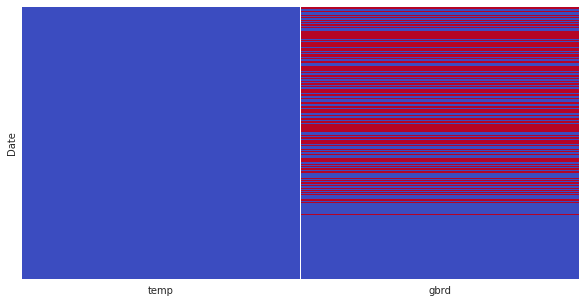

In [29]:
plt.figure(figsize=(10,5))
sns.heatmap(gbrd_df_by_temp[['temp',"gbrd"]].isnull(),cmap='coolwarm', cbar=False, yticklabels=False);


The radiation column has very high missing values and quite scattered. Lets apply temp fill function with context as gbrd.

In [30]:
sample_df['gbrd'] = sample_df[['temp','gbrd']].apply(fill_missing_by_temp,context= "gbrd", axis=1)


Just for the sake of argument fill the missing values in dewp, dmax with average values

### Dewpoint 


Dew point has highest correlation with humyidity and then with temperature.Lets fill their values by dewp

In [31]:
# First drop hmin and hmax na values

sample_df.dropna(subset=['hmax','hmin'],inplace=True)


Plotting heatmap will not be fruitfull because the relative size of null values to the total lenght of df is quite low so, the heatmap will not show the null values. 
Lets just use pct table we created earlier.

 

In [32]:
print(null_pct_df.T.astype(int))

               prcp    gbrd  temp  dewp  tmax  dmax  tmin  dmin  hmax  hmin  \
null_counts  256796  126306     1    10     3    11     1    26     1     1   
null_pct         85      42     0     0     0     0     0     0     0     0   

              wdsp  gust  
null_counts  28458  9733  
null_pct         9     3  


In [33]:
# Check out intervals

sample_df.hmdy.value_counts(bins=3).sort_index()

(-0.101, 33.333]     34002
(33.333, 66.667]     84705
(66.667, 100.0]     181287
Name: hmdy, dtype: int64

In [34]:
# Create three mean 
first_range_mean_dwep_by_humidity= sample_df[sample_df['hmdy']<33.333]['dewp'].mean()
second_range_mean_dwep_by_humidity=sample_df[((sample_df['hmdy']>=33.333) &(sample_df['hmdy']<66.667))]['dewp'].mean()
third_range_mean_dwep_by_humidity=sample_df[sample_df['hmdy']>= 66.667 ]['dewp'].mean()

In [35]:
#math is imported to check nan, np.nan wont work
def fill_dewp_by_humidity(col): 
    
    
#Initialize relevant cols
    hmdy = col[0]
    dewp = col[1]
    
    # If the value is nan
    #Assign by ranges declared above
    import math
    if math.isnan(dewp):
        if (hmdy<33.333):
            return first_range_mean_dwep_by_humidity
        elif (hmdy>=33.333 ) and (hmdy<66.667):
            return second_range_mean_dwep_by_humidity
        elif (hmdy>=66.667):
            return third_range_mean_dwep_by_humidity
          #if not nan return as it is
    else:
        return dewp
    

Lets apply the func to all dewp variables

In [36]:
sample_df['dewp'] = sample_df[["hmdy", "dewp"]].apply(fill_dewp_by_humidity, axis=1)
sample_df['dmin'] = sample_df[["hmdy", "dmin"]].apply(fill_dewp_by_humidity, axis=1)
sample_df['dmax'] = sample_df[["hmdy", "dmax"]].apply(fill_dewp_by_humidity, axis=1)

Only column with null value is prcp, which is also a dependent column. Hence leave it at that for now. Create new df for analysis without prcp. Moreover, some analysis is faster using the normalized version so lets created a normalized dataframe too.


# Data Analysis

In [37]:
# New df without prcp
df = sample_df[['elvt', 'lat', 'lon','city', 'prov', 'stp', 'smax', 'smin', 'gbrd', 'temp',
       'dewp', 'tmax', 'dmax', 'tmin', 'dmin', 'hmdy', 'hmax', 'hmin', 'wdsp',
       'wdct', 'gust']].copy()



In [38]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#Make a copy from the original df first

normed_df = df.copy()
# EXtract cols with non-string values
float_cols = df.columns[df.dtypes =="float64" ].tolist()
# Normed df 
normed_df[float_cols] =scaler.fit_transform(normed_df[float_cols])

## Questions To Explore
1. Data Share by Province
2. Avg air pressure by Province per year
3. Avg air pressure by City per year
4. Air pressure per city comparision
5. Where can u cook faster? Air pressure
6. Compare temperatures of different cities
7.  Days with most fluctuations like temp,wind
8. Temperature Change weekly,monthly or yearly
9. Seasonal Forecasting
10. Different Variables and their relation with each-other.like wind with humidity.
11. Gusty city of all time

### Data share By Province

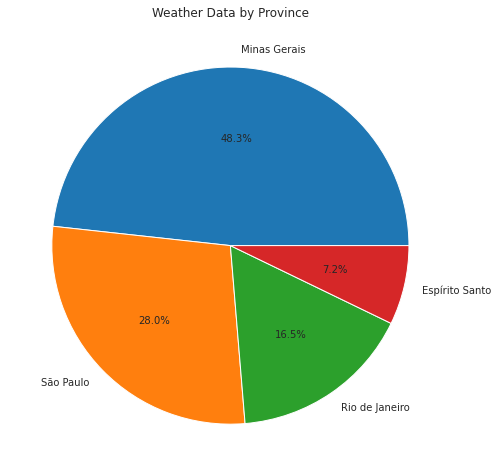

In [39]:
df['prov'].value_counts(normalize=True).plot.pie(figsize=(8,10),autopct = '%.1f%%',
                                                 labels=['Minas Gerais','São Paulo','Rio de Janeiro','Espírito Santo'])
plt.xlabel("")
plt.ylabel("")
plt.title('Weather Data by Province');



It seems abot 50% of the data is related to *Minas Gerlas* province of Brazil

#### Columns and Measurement scale

City and Province are categorical, nominal values. All other columns are quantitative,continuous and ratio scale. 

In [40]:
gr_by_city = normed_df[['prov','city', 'stp', 'smax', 'smin', 'gbrd', 'temp',
                  'dewp', 'tmax', 'dmax', 'tmin', 'dmin', 'hmdy', 
                  'hmax', 'hmin', 'wdsp','wdct', 'gust']].groupby('city').mean()

gr_by_prov = normed_df[['prov','city', 'stp', 'smax', 'smin', 'gbrd', 'temp',
                             'dewp', 'tmax', 'dmax', 'tmin', 'dmin','hmdy', 
                        'hmax', 'hmin', 'wdsp','wdct', 'gust']].groupby(['prov']).mean()

In [41]:
gr_by_city.columns

Index(['stp', 'smax', 'smin', 'gbrd', 'temp', 'dewp', 'tmax', 'dmax', 'tmin',
       'dmin', 'hmdy', 'hmax', 'hmin', 'wdsp', 'wdct', 'gust'],
      dtype='object')

In [42]:
gr_by_yr_prov = normed_df.groupby([normed_df.index.year,'prov']).mean().unstack(level=0)

In [45]:
layout = dict(xaxis_title="City",
              yaxis_title="Frequency Normalized",
              title="Avg. Temp by City")
gr_by_city[('temp')].iplot(kind="bar", layout=layout);

In [46]:

# Change name for better labels in legend
# 'stp', 'smax', 'smin', 'gbrd', 'temp', 'dewp', 'tmax', 'dmax', 'tmin',
#        'dmin', 'hmdy', 'hmax', 'hmin', 'wdsp', 'wdct', 'gust'
cols_to_plot =['stp','gbrd', 'temp', 'dewp', 'hmdy', 'wdsp', 'gust']
cols_changed_name ={"Air Pressure","Solar Radiation", "Temperature","Dew Point","Humidity", "Windspeed","Gust"}


temp_df = gr_by_prov[cols_to_plot]

temp_df.columns = cols_changed_name


In [47]:
layout = dict(xaxis = dict( tickvals =["ES","MG","RJ","SP"],
                           ticktext=['Espírito Santo','Minas Gerais','Rio de Janeiro','São Paulo']),
             legend_title_text='Weather Factors',
              xaxis_title="Provinces",
              yaxis_title="Frequency Normalized",
              title = "Avg Weather Factors by Provinces",)
temp_df.iplot(kind="bar",  layout=layout);
#names = ["Air pressure","Solar Radiation", "Temperature", "Dewpoint", "Humidity","Windspeed","Gust"])

          

Province *Espirito Santo* is taking the top spot on average weather factors by province. While *Minas Gerias* and *Rio de Janerio* both share similar triats. 

In [48]:
# sample_df[['prcp',"city"]].groupby(['city', df.index.year]).mean().unstack(level=1)
#
temp_yearly=pd.pivot_table(data= sample_df,index="city", columns=sample_df.index.year,values="temp")
# temp_yearly_normed=pd.pivot_table(data= normed_df,index="city", columns=sample_df.index.year,values="temp")



In [112]:
l= dict(showlegend=False, title="Yearly Average Temperature", xaxis_title="Year", yaxis_title="Frequecny")
temp_yearly.iplot(kind="box",layout=l)

Year 2011 has least fluctuations, data in early 2000's are incomplete. 

In [219]:

# temp_yearly.iplot(secondary_y = min_values)
layout= dict(yaxis_title="Frequency",xaxis_title="City", title="Average Yearly Temperature by Cities",)
temp_yearly.iplot(kind="scatter", mode="lines+markers", layout=layout)

In 2016, which is the latest record, Guaruja,is the coldest city and "Sao Goncalo" is the hottest city. 

Looks like 2013-2016 have been periods of ups and downs. Average temperature  fell from about 20.5 to  16.5 from 2013 t0 2014 and again rose to about 22 degrees on average and theres slopy journey again to 2016.

Lets normalize the dataset first to neutralize different units

In [99]:
from sklearn.preprocessing import MinMaxScaler

In [100]:
scaler = MinMaxScaler()

# Take a copy of sample_df
sample_df_norm = sample_df.copy()

#Columns to normalize
cols_to_norm = ['elvt', 'lat', 'lon', 'prcp', 'stp', 'smax', 'smin','gbrd', 'temp', 'dewp', 'tmax', 'dmax', 'tmin', 'dmin',
                'hmdy', 'hmax','hmin', 'wdsp', 'wdct', 'gust']

#Normalize numeric scales
sample_df_norm.loc[:,cols_to_norm] = scaler.fit_transform(sample_df.loc[:,cols_to_norm])

## Temperature


In [101]:
### Seasonal Fluctuations- Tempearature

# Assuming 4 mnths seasons
# Lets obsorve seasoal fluctuation
layout= dict(yaxis_title="Frequency",xaxis_title="Years", title="Average Seasonal Temperature Distribution",)
sample_df_norm[['temp','tmin',"tmax"]].resample('M').mean().rolling(4).mean().iplot(kind="bar",layout=layout )


On average fluctation was noticeable during yr 2001 and 2006. Slightly however, there is constant sloppy decrease in temp from 2004 to 2006, lowest temperatures comparing to other years. 

From year 2010-2016 the temperatures are steady and warmer.

### Temperature dataframe

In [ ]:
temperature_df=sample_df[['city','temp','tmax','tmin']]

In [ ]:
def get_temp_by_choice(yr,mo,c):
    # Get temperature record by given month and year
    temp_m_y_c=temperature_df[(temperature_df.index.year==yr) & (temperature_df.index.month==mo) & (temperature_df.city == c)]
    
    
    # Extract given city from  above record
    temp_max = temp_m_y_c.max()
    temp_min = temp_m_y_c.min()
    print(temp_max)
    print(temp_min)
    print("=="*20)
#     return temp_max, temp_min

Now we can extract temp records of our choice lets, try few.

In [178]:
get_temp_by_choice(2008,10,"Viçosa")
get_temp_by_choice(2008,10,"Valença")
get_temp_by_choice(2008,10,"Montalvânia")
get_temp_by_choice(2008,10,"Itaobim")

city    Viçosa
temp      33.2
tmax      33.5
tmin      32.2
dtype: object
city    Viçosa
temp      11.5
tmax      11.9
tmin      11.3
dtype: object
city    Valença
temp       26.6
tmax       27.1
tmin       26.6
dtype: object
city    Valença
temp       15.8
tmax       15.8
tmin       15.7
dtype: object
city    Montalvânia
temp             37
tmax           38.2
tmin           36.6
dtype: object
city    Montalvânia
temp           20.5
tmax           22.8
tmin           19.8
dtype: object
city    Itaobim
temp       33.4
tmax         35
tmin       33.4
dtype: object
city    Itaobim
temp       18.3
tmax       18.3
tmin       17.7
dtype: object


In October of 2008, *Viçosa* was the coldest and *Montalvânia* was the hottest one.

### Plot By Custom Choice
The following function will plot Average temperature of given list of citeis in  bar  plot some timeline of choice.

In [210]:
timeline={"Weekly":"W","Monthly":"M","Yearly":"Y"}


def temp_analysis(cities, time_line="Yearly"):
    """provide timeline among weekly, monthly or yearly. The default value is Yearly.
     Function takes  two  arguments 
     1. cities, which is list of cites
     2. time_line, which has three values, weekly, yearly, or monthly
    for eg: temp_analysis(['Viçosa','Mantena','Formiga',"São João del Rei","Juiz de Fora" ], "Yearly")

"""
    print(temp_analysis.__doc__)
    
    c =pd.DataFrame()
    # Extract given city from  above record
    for city in cities:
        c= c.append(temperature_df[temperature_df['city'] == city])
    
    # Resample it on average
    #title() takes care of uppercase and lowercase confusion
    d=c.resample(timeline[time_line.title()]).mean()
    print("Temperature of cities {}".format(cities))

   
    # Plot the data
    layout= dict( title='Avg Temperatures {}'.format(time_line.upper()), xaxis_title="Years", yaxis_title="Temperatures")
    d[['tmax','tmin','temp']].iplot(kind="bar", layout=layout)


In [220]:
temp_analysis(['Viçosa','Mantena','Formiga',"São João del Rei","Juiz de Fora" ], "Weekly")

provide timeline among weekly, monthly or yearly. The default value is Yearly.
     Function takes  two  arguments 
     1. cities, which is list of cites
     2. time_line, which has three values, weekly, yearly, or monthly
    for eg: temp_analysis(['Viçosa','Mantena','Formiga',"São João del Rei","Juiz de Fora" ], "Yearly")


Temperature of cities ['Viçosa', 'Mantena', 'Formiga', 'São João del Rei', 'Juiz de Fora']


If the weekly timeline is provided on zooming in the max temp week is From Jan 18-25,2015

## Airpressure

In [180]:
# Assuming 4 mnths seasons
# Lets obsorve seasoal fluctuation
layout= dict(yaxis_title="Frequency",xaxis_title="Years", title="Average Seasonal Pressure Distribution",)
sample_df_norm[['stp','smin',"smax"]].resample('M').mean().rolling(4).mean().iplot(kind="bar",layout=layout )


Air pressure and temperature  seasonal dist show similar behaviour accoring to plot.

### Sketching the chart for specific air pressure values with year, month and city

Create a function which shows the data from given year, month and city name then plots it

### Airpressure Dataframe

In [ ]:
# df for airpressure only
air_df=sample_df[['city','prov','stp','smax','smin']]

In [173]:
def monthly_plot(m,y,cities):
    '''  Function takes  three arguments month in number, year in int and list of cities to compare
    for eg: monthly_plot(10,2008,['Viçosa','Mantena','Formiga',"São João del Rei","Juiz de Fora" ])


    '''
    print(monthly_plot.__doc__)
  
    # Get pressure record by given month and year
    air_m_y=air_df[(air_df.index.month == m) & (air_df.index.year == y)]
    air_m_y_c =pd.DataFrame()
    # Extract given city from  above record
    for c in cities:
        air_m_y_c = air_m_y_c.append(air_m_y[air_m_y['city'] == c])
    
    grp_by_c = air_m_y_c.groupby('city').mean()
    layout= dict( title='Avg Air pressure of city {}-{}'.format(m,y), xaxis_title="Cities", yaxis_title="Air pressure")
    grp_by_c.iplot(kind="bar",layout=layout)

Lets check some cities from same province first, during same times.


In [165]:
# For prov "MG"
minas_cities = air_df[air_df.prov=="MG"].city
# lets just use 5 cities at random
minas_cities[:5]

Date
2011-12-20              Viçosa
2011-01-13        Juiz de Fora
2016-03-30             Mantena
2011-07-06    São João del Rei
2007-07-06             Formiga
Name: city, dtype: object

In [174]:
monthly_plot(10,2008,['Viçosa','Mantena','Formiga',"São João del Rei","Juiz de Fora" ])

  Function takes  three arguments month in number, year in int and list of cities to compare
    for eg: monthly_plot(10,2008,['Viçosa','Mantena','Formiga',"São João del Rei","Juiz de Fora" ])


    


City *Maneta* is the only one with air pressure in the upper range around the year, while *Vicosa's* in the middle range and other 3 are in lower range.

## Gusty City of All Time

In [108]:
gust_yr_city = sample_df_norm.pivot_table(columns=sample_df_norm.index.year,index='city',values=['gust'],aggfunc='mean').stack()


In [109]:
gusty_city= gust_yr_city.loc[gust_yr_city['gust']==gust_yr_city.gust.max()].index[0]
gusty_city

('Petrópolis', 2007)

Among the cities, the gusty city is "Petrópolis" in year 2007.

# Variables and Correlations

## Heatmap of Corr

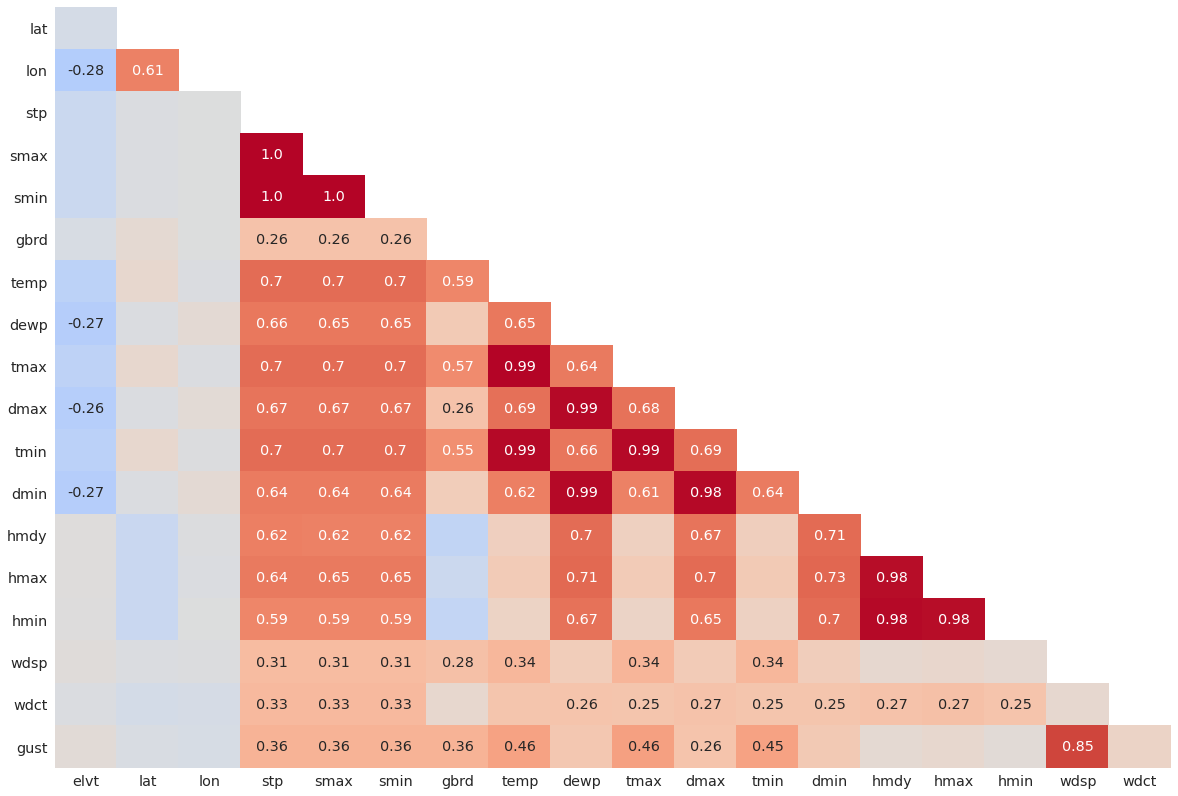

In [212]:
customized_heatmap(normed_df)

Above heatmap shows obvious high correlation between similar variables like (temp,tmax and tmin), (stp,smax and smin) and so on. However, it shows higher correaltion btween variables of dew points with humidity. It can implied that more due forms for humidity. The jointplot "Dew and Humidity" also proves the point. Moreover, the aspect of temperature(temp,tmax and tmin) and airpressure (stp,smax and smin) also have high correlation between them.  

It appears aspects wind-speeds have very low correlatoin with humidity. Windspeed and Humidity plot below will make this more clear.  

### Dew and Humidity

<Figure size 720x720 with 0 Axes>

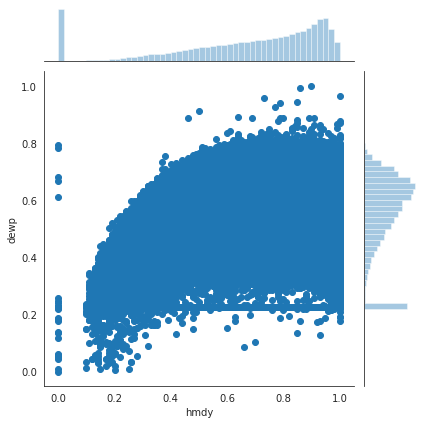

In [222]:
# fig = plt.figure(figsize=(10,10))
sns.jointplot(normed_df['hmdy'],normed_df['dewp']);
# plt.savefig("Humidity vs Dewpoint")

### Humidity and WindSpeed

KeyboardInterrupt: 

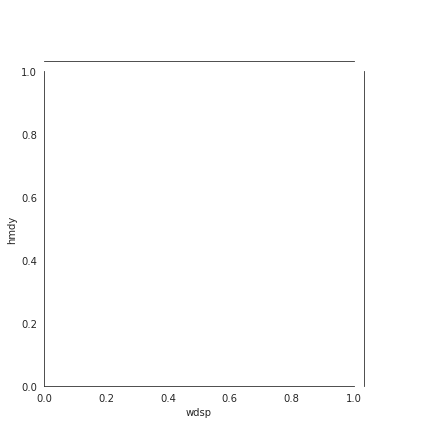

In [223]:
fig = plt.figure(figsize=(10,10))
sns.jointplot(normed_df['wdsp'],normed_df['hmdy'], kind='kde', title="Windspped vs Humidty");
plt.savefig("Windspped vs Humidty Density Plot")

The plot is denser on the left and botteom. So, it seems wind-speed and humidity are reversely proportional to each other. Increase in wind-speed causes decrease in humidity. Also the humidity is right skewed data.